In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_predictor.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 18657.40455758211
R² Score: 0.9763972145696175

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 805.40 metric tons
Recommendation: Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN model
model = KNeighborsRegressor(n_neighbors=5)  # You can experiment with different values of k
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_predictor_knn.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} units")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 40796.21911922057
R² Score: 0.9483902274150708

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 380.00 units
Recommendation: Not Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_predictor_linear_regression.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} units")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 19401.17470798813
R² Score: 0.9754562987409782

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 511.98 units
Recommendation: Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_predictor_gradient_boosting.pkl')

# Define the rest of the functions as in your original code
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        avg_yield = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean() or data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 29560.345749393276
R² Score: 0.9626043110220649

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 696.52 metric tons
Recommendation: Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Standardize features for SVR
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model for regression
model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reverse scaling for predictions and true values for accurate metrics
# Reverse scaling for predictions and true values for accurate metrics
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model and scalers
joblib.dump(model, 'crop_yield_predictor_svm.pkl')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# Define functions to get validated area input and make predictions as in your original code
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

def predict_yield(season_encoded, crop, area, state):
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    previous_yield = previous_yield_data['Yield'].iloc[-1]

    input_data = pd.DataFrame([[season_encoded, area, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    input_data = scaler_X.transform(input_data)
    predicted_yield_scaled = model.predict(input_data)
    predicted_yield = scaler_y.inverse_transform(predicted_yield_scaled.reshape(-1, 1)).flatten()[0]

    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    avg_yield = avg_yield_row['Average_Yield'].values[0] if not avg_yield_row.empty else data['Yield'].mean()
    recommendation = "Good" if predicted_yield >= avg_yield else "Not Good"

    return predicted_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")

Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 50423.62655341683
R² Score: 0.936210953967958

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 32.98 metric tons
Recommendation: Not Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_predictor_decision_tree.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 29081.643032527423
R² Score: 0.963209899943946

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 400.00 metric tons
Recommendation: Not Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the AdaBoost model
base_estimator = DecisionTreeRegressor(max_depth=4, random_state=42)  # Base estimator for AdaBoost
model = AdaBoostRegressor(estimator=base_estimator, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_adaboost.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


<ipython-input-4-d8099023db65>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
<ipython-input-4-d8099023db65>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
<ipython-input-4-d8099023db65>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 19125.948374432548
R² Score: 0.9758044772925905

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 627.76 metric tons
Recommendation: Good


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv('crop_yield.csv')

# Handle missing values (if any)
data = data.dropna()

# Create 'Previous_Yield' column to store yield from the previous year for the same crop and state
data = data.sort_values(['Crop', 'State', 'Crop_Year'])
data['Previous_Yield'] = data.groupby(['Crop', 'State'])['Yield'].shift(1)

# Drop rows where 'Previous_Yield' is NaN
data = data.dropna(subset=['Previous_Yield'])

# Encode categorical columns: 'Season', 'Crop', and 'State'
label_encoder_season = LabelEncoder()
label_encoder_crop = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit encoders on all unique values
data['Season_encoded'] = label_encoder_season.fit_transform(data['Season'])
data['Crop_encoded'] = label_encoder_crop.fit_transform(data['Crop'])
data['State_encoded'] = label_encoder_state.fit_transform(data['State'])

# Display season encoding for user reference
season_mapping = dict(zip(label_encoder_season.classes_, range(len(label_encoder_season.classes_))))
print("Season encoding:", season_mapping)

# Calculate average yield for each crop, state, and season combination
average_yields = data.groupby(['Crop_encoded', 'State_encoded', 'Season_encoded'])['Yield'].mean().reset_index()
average_yields = average_yields.rename(columns={'Yield': 'Average_Yield'})

# Select features and target variable
X = data[['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield']]
y = data['Yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and display model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Save the trained model
joblib.dump(model, 'crop_yield_xgboost.pkl')

# Function to get validated area input from the user
def get_area_input():
    while True:
        try:
            area = float(input("Enter Area (in hectares): "))
            if area <= 0:
                print("Area should be a positive number. Please try again.")
            else:
                return area
        except ValueError:
            print("Invalid input. Please enter a numeric value for the area.")

# Define a function to make predictions and give recommendations based on user input
def predict_yield(season_encoded, crop, area, state):
    # Check if the crop and state exist in the dataset
    if crop not in label_encoder_crop.classes_ or state not in label_encoder_state.classes_:
        print("Error: Crop or State not found in the dataset.")
        return None, None

    # Encode crop and state
    crop_encoded = label_encoder_crop.transform([crop])[0]
    state_encoded = label_encoder_state.transform([state])[0]

    # Retrieve the most recent previous yield for this crop and state
    previous_yield_data = data[(data['Crop_encoded'] == crop_encoded) & (data['State_encoded'] == state_encoded)]
    if previous_yield_data.empty:
        print("No previous yield data available for this crop and state.")
        return None, None

    # Get the most recent previous yield
    previous_yield = previous_yield_data['Yield'].iloc[-1]

    # Prepare the input data for prediction (with Area set to 1 hectare)
    input_data = pd.DataFrame([[season_encoded, 1, crop_encoded, state_encoded, previous_yield]],
                              columns=['Season_encoded', 'Area', 'Crop_encoded', 'State_encoded', 'Previous_Yield'])

    # Predict the yield per hectare
    predicted_yield_per_hectare = model.predict(input_data)[0]

    # Scale the yield to the user's specified area
    total_yield = predicted_yield_per_hectare * area

    # Try to find the exact average yield for the crop, state, and season
    avg_yield_row = average_yields[(average_yields['Crop_encoded'] == crop_encoded) &
                                   (average_yields['State_encoded'] == state_encoded) &
                                   (average_yields['Season_encoded'] == season_encoded)]

    if not avg_yield_row.empty:
        avg_yield = avg_yield_row['Average_Yield'].values[0]
    else:
        # Fallback: Use the crop's average yield across all states and seasons
        avg_yield_crop = data[data['Crop_encoded'] == crop_encoded]['Yield'].mean()
        if not pd.isna(avg_yield_crop):
            avg_yield = avg_yield_crop
        else:
            # Final fallback: Use the overall average yield in the dataset
            avg_yield = data['Yield'].mean()

    # Provide recommendation based on comparison with average yield per hectare
    recommendation = "Good" if predicted_yield_per_hectare >= avg_yield else "Not Good"

    return total_yield, recommendation

# Example usage
print("\nPlease enter values for prediction based on the following mappings:")

# Ask for season as encoded integer
try:
    season_input = int(input(f"Enter Season (encoded as {season_mapping}): "))
except ValueError:
    print("Invalid season encoding. Please enter a numeric code corresponding to the season mapping.")
    season_input = None

if season_input is not None:
    crop_input = input("Enter Crop (e.g., 'Cotton(lint)'): ")
    area_input = get_area_input()
    state_input = input("Enter State (e.g., 'Assam'): ")

    # Predict yield and recommendation
    predicted_yield, recommendation = predict_yield(season_input, crop_input, area_input, state_input)
    if predicted_yield is not None:
        print(f"Predicted Yield for {area_input} hectares: {predicted_yield:.2f} metric tons")
        print(f"Recommendation: {recommendation}")
    else:
        print("Prediction could not be made.")


Season encoding: {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}
Mean Squared Error: 25824.054994154973
R² Score: 0.9673309528617292

Please enter values for prediction based on the following mappings:
Enter Season (encoded as {'Autumn     ': 0, 'Kharif     ': 1, 'Rabi       ': 2, 'Summer     ': 3, 'Whole Year ': 4, 'Winter     ': 5}): 2
Enter Crop (e.g., 'Cotton(lint)'): Rice
Enter Area (in hectares): 200
Enter State (e.g., 'Assam'): Tamil Nadu
Predicted Yield for 200.0 hectares: 741.77 metric tons
Recommendation: Good


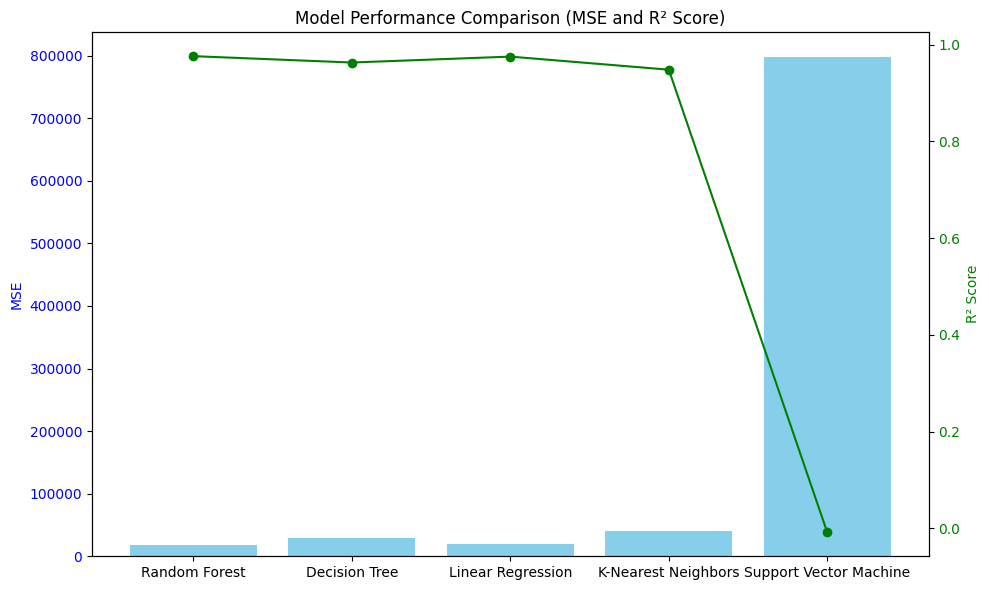

In [ ]:
# Import additional models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Initialize and train the models (adding KNN and SVM)
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Machine': SVR()
}

# To store metrics for each model
model_metrics = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_metrics[name] = {'MSE': mse, 'R2': r2}

# Prepare data for visualization
model_names = list(model_metrics.keys())
mse_values = [model_metrics[model]['MSE'] for model in model_names]
r2_values = [model_metrics[model]['R2'] for model in model_names]

# Plotting the graph for MSE and R² values
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE
ax1.bar(model_names, mse_values, color='skyblue', label='Mean Squared Error (MSE)')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot R² on the same graph
ax2 = ax1.twinx()
ax2.plot(model_names, r2_values, color='green', marker='o', label='R² Score')
ax2.set_ylabel('R² Score', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and labels
plt.title('Model Performance Comparison (MSE and R² Score)')
plt.xticks(rotation=15)
fig.tight_layout()
plt.show()


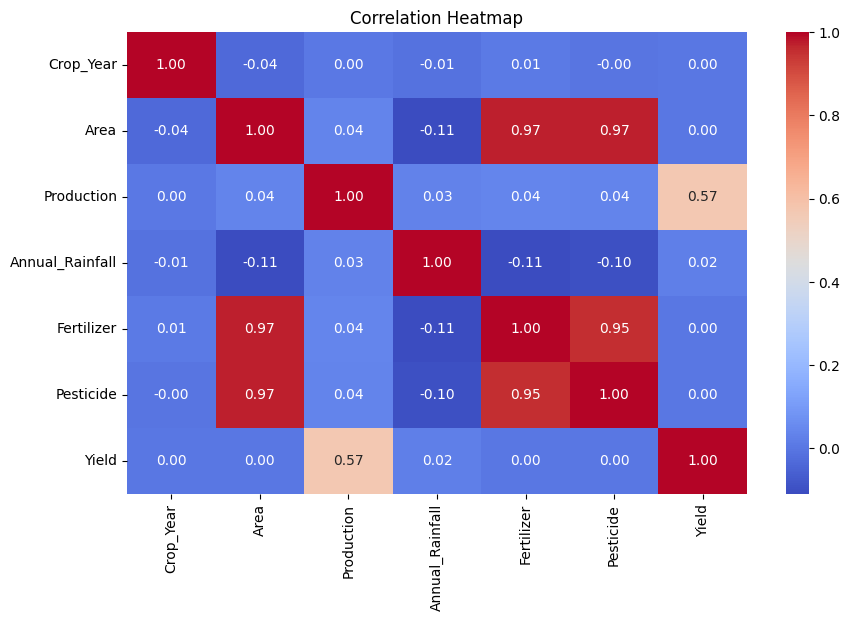

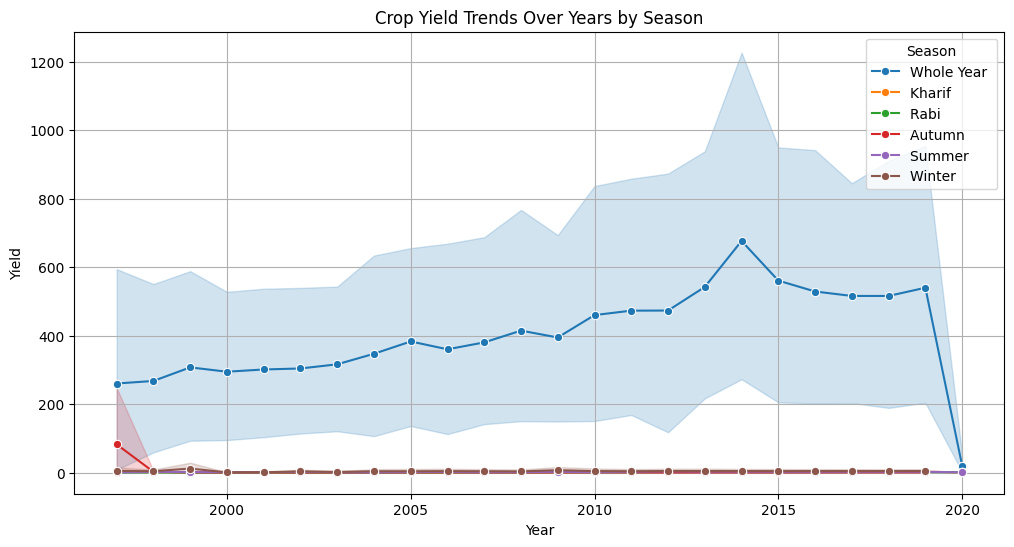

<ipython-input-10-24f2783ad7bb>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='Crop', y='Yield', palette='Set2')


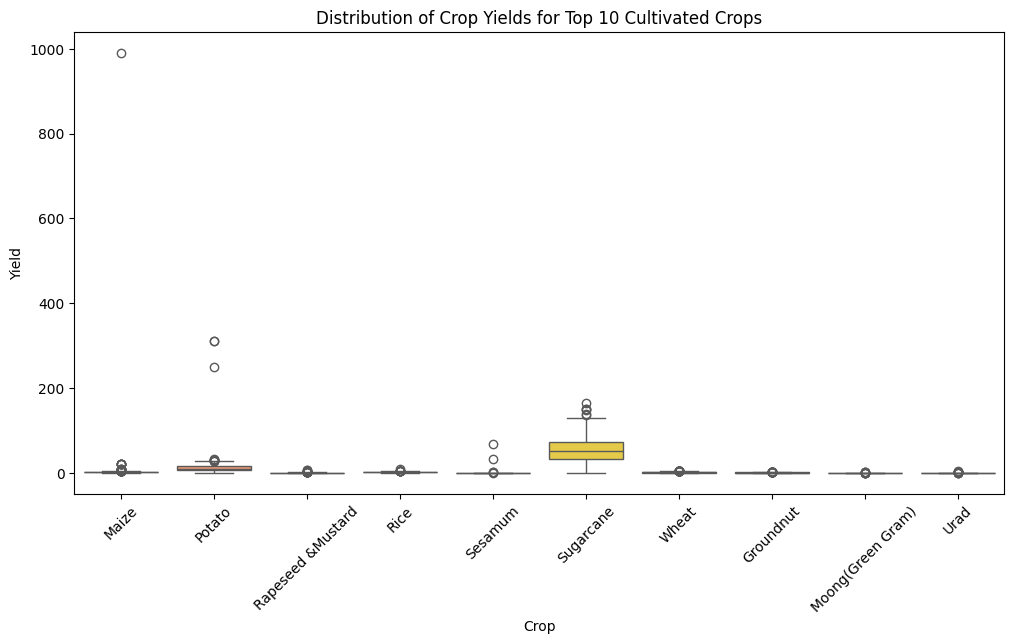

<ipython-input-10-24f2783ad7bb>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_yield_by_state.index, y=avg_yield_by_state.values, palette='Blues_d')


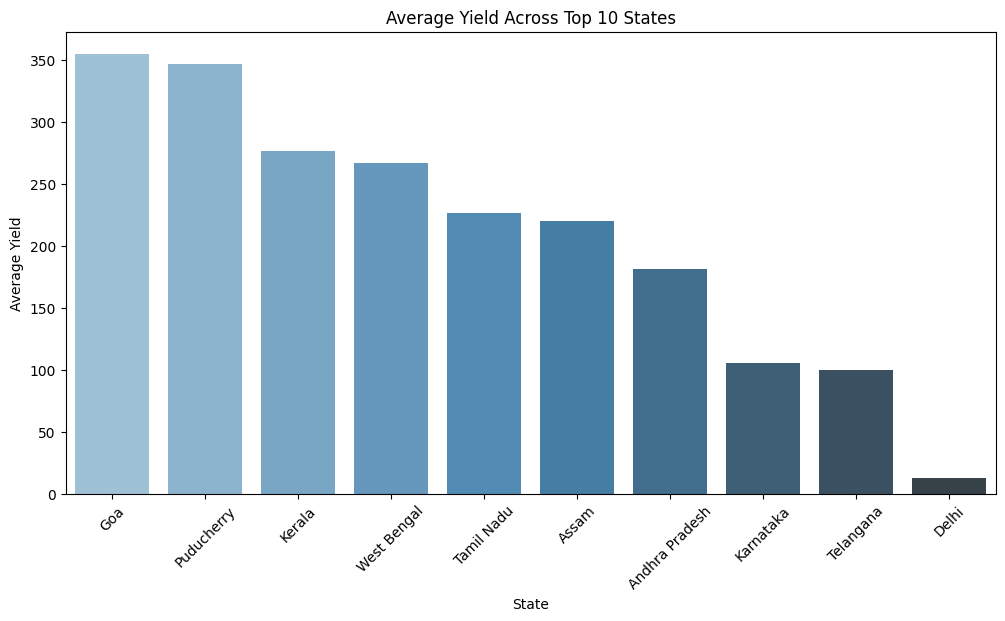

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'crop_yield.csv'  # Replace with your file path if different
data = pd.read_csv(file_path)

# Ensure column names are accessible
data.columns = data.columns.str.strip()

# 1. Heatmap: Correlation between numerical features
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 2. Line Plot: Crop yield trends over the years, grouped by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Crop_Year', y='Yield', hue='Season', marker='o')
plt.title('Crop Yield Trends Over Years by Season')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# 3. Box Plot: Distribution of crop yields for the top 10 most cultivated crops
top_crops = data['Crop'].value_counts().head(10).index
filtered_data = data[data['Crop'].isin(top_crops)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='Crop', y='Yield', palette='Set2')
plt.title('Distribution of Crop Yields for Top 10 Cultivated Crops')
plt.xticks(rotation=45)
plt.xlabel('Crop')
plt.ylabel('Yield')
plt.show()

# 4. Bar Plot: Average yield across top 10 states with highest average yield
avg_yield_by_state = data.groupby('State')['Yield'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_yield_by_state.index, y=avg_yield_by_state.values, palette='Blues_d')
plt.title('Average Yield Across Top 10 States')
plt.xlabel('State')
plt.ylabel('Average Yield')
plt.xticks(rotation=45)
plt.show()
